In [1]:
#QCNN https://www.tensorflow.org/quantum/tutorials/qcnn?hl=ja

#4 * 2 qubit のQCNN
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import AdagradOptimizer
import matplotlib.pyplot as plt

In [2]:
def one_qubit_unitary(wires, params):
    qml.RX(params[0], wires=wires)
    qml.RY(params[1], wires=wires)
    qml.RZ(params[2], wires=wires)

def two_qubit_unitary(wires, params):
    one_qubit_unitary(wires[0], params[0:3])
    one_qubit_unitary(wires[1], params[3:6])
    qml.IsingZZ(params[6], wires=wires)
    qml.IsingYY(params[7], wires=wires)
    qml.IsingXX(params[8], wires=wires)
    one_qubit_unitary(wires[0], params[9:12])
    one_qubit_unitary(wires[1], params[12:])

def two_qubit_pool(source_wire,sink_wire ,params):
    one_qubit_unitary(sink_wire, params[0:3])
    one_qubit_unitary(source_wire, params[3:6])
    qml.CNOT(wires=[source_wire, sink_wire])
    qml.RZ(-1 *params[2], wires=sink_wire)
    qml.RY(-1 * params[1], wires=sink_wire)
    qml.RX(-1* params[0], wires=sink_wire)    

#params.shape = (15,)
def quantum_conv(wires, params):
    for first, second in zip(wires[0::2], wires[1::2]):
        two_qubit_unitary([first,second], params)
    for first, second in zip(wires[1::2], wires[2::2]+[wires[0]]):
        two_qubit_unitary([first,second], params)
    
    #回路の可読性のために挿入、動作に影響しない  
    for w in wires:
        qml.Barrier(w)

#params.shape = (6,)
def quantum_pool(source_wires, sink_sires, params):
    for source, sink in zip(source_wires, sink_sires):
        two_qubit_pool(source, sink,params)


In [3]:
#HWE回路のパラメータの読み込み
weights_005= np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/4_Qubits/Depth_6/hwe_4q_ps_5_6_weights.npy')
weights_035= np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/4_Qubits/Depth_6/hwe_4q_ps_35_6_weights.npy')

#データセットの読み込み
train_path = '/home/ryo_mtmt/xanadu_ntangle_dataset/train_HWE_4q_6_005_035_no3.csv'
train_data = np.loadtxt(train_path, delimiter=',',)
X_train = train_data[:, :-1] 
y_train = train_data[:, -1]

test_path = '/home/ryo_mtmt/xanadu_ntangle_dataset/test_HWE_4q_6_005_035_no3.csv'
test_data = np.loadtxt(test_path, delimiter=',',)
X_test = test_data[:, :-1] 
y_test = test_data[:, -1] 


In [4]:
features = 4
copy = 2
n_wires = features * copy

dev = qml.device('default.qubit', wires=n_wires)
@qml.qnode(dev)
def circuit(params,x):

    #HWE回路のパラメータの選択
    if x[-1] == -1:
        gen_params = weights_005
    else:
        gen_params = weights_035
    x = x[:-1]
    x = x.reshape( ( int(x.shape[0]/2) , 2) )

    for j in range(copy):

        #積状態の入力
        for i in range(features):
            qml.RZ(x[i][1],wires=i + features*j)
            qml.RY(x[i][0],wires=i + features*j)
        
        #HWE回路
        for layer in range(gen_params.shape[0]):
            for i in range(features):
                qml.U3(gen_params[layer][i][0],gen_params[layer][i][1],gen_params[layer][i][2],wires=i + features*j)
            for i in range(int(features/2)):
                qml.CZ(wires=[2*i+ features*j,2*i+1+ features*j])
            for i in range(features):
                qml.U3(gen_params[layer][i][0],gen_params[layer][i][1],gen_params[layer][i][2],wires=i + features*j)
            for i in range(int((features-1)/2)):
                qml.CZ(wires=[2*i+1 + features*j,2*i+2 + features*j])

    #QQCNN
    quantum_conv([0,1,2,3,4,5,6,7],params[0:15])
    quantum_pool([0,1,2,3],[4,5,6,7],params[15:21])
    quantum_conv([4,5,6,7], params[21:36])
    quantum_pool([4,5],[6,7],params[36:42])
    quantum_conv([6,7],params[42:57])
    quantum_pool([6],[7],params[57:63])

    return qml.expval(qml.PauliZ(7))


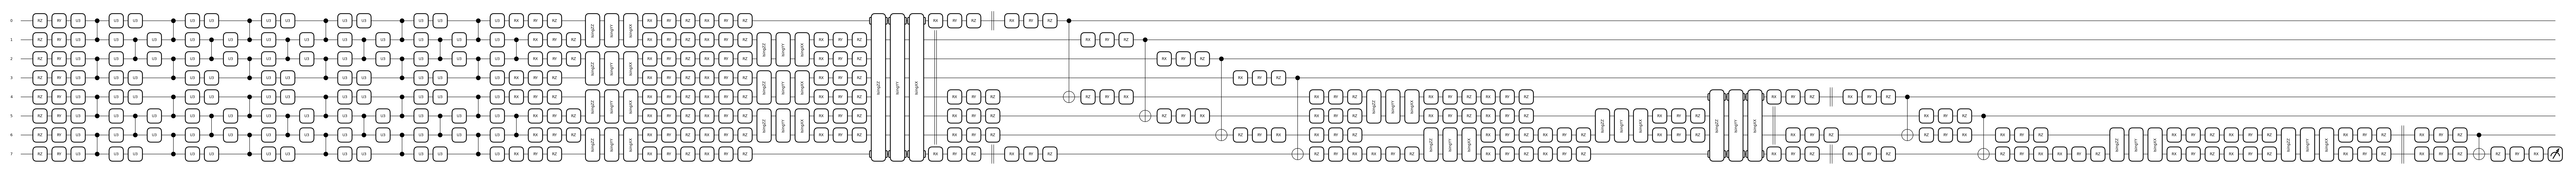

Cost after step 1: 1.007908659931223
Cost after step 2: 1.0069055664656683
Cost after step 3: 1.0061605756105707
Cost after step 4: 1.0056026495586388
Cost after step 5: 1.0051497216151573
Cost after step 6: 1.0047485473503557
Cost after step 7: 1.0043793751764505
Cost after step 8: 1.004039806778529
Cost after step 9: 1.003733491109564
Cost after step 10: 1.0034649255871484
Cost after step 11: 1.0032372907907217
Cost after step 12: 1.003051989014701
Cost after step 13: 1.00290858748515
Cost after step 14: 1.0028046895272125
Cost after step 15: 1.0027360841905306
Cost after step 16: 1.002696377963346
Cost after step 17: 1.002676323510971
Cost after step 18: 1.0026651089430376
Cost after step 19: 1.0026535465508484
Cost after step 20: 1.002636381802588
Cost after step 21: 1.0026121437338333
Cost after step 22: 1.0025815917793446
Cost after step 23: 1.0025462402749916
Cost after step 24: 1.0025075255067382
Cost after step 25: 1.002466540653999
Cost after step 26: 1.002424098263175
Cost a

In [5]:
#パラメータの初期値をランダムに決定
np.random.seed(42) 
params = np.random.rand(63, 1) * (2 * np.pi)
params.requires_grad = True  # 勾配計算の有効化

#コスト関数
def loss(p):
    predictions = np.array([circuit(p, x) for x in X_train])
    return np.mean((predictions - y_train) ** 2)

#オプティマイザーとエポック数の指定
opt = AdamOptimizer(0.01)
steps = 100

fig, ax =qml.draw_mpl(circuit)(params, X_train[0])
plt.show()
plt.close()
#print(qml.draw(circuit)(params,X_train[0]))

loss_values = []
loss_values.append(loss(params))
for i in range(steps):
    params = opt.step(loss, params)
    current_loss = loss(params)
    loss_values.append(current_loss)
    print(f"Cost after step {i + 1}: {current_loss}")
        
predictions = np.array([np.sign(circuit(params, x)) for x in X_test])
accuracy = np.mean(predictions == y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

print(loss_values)

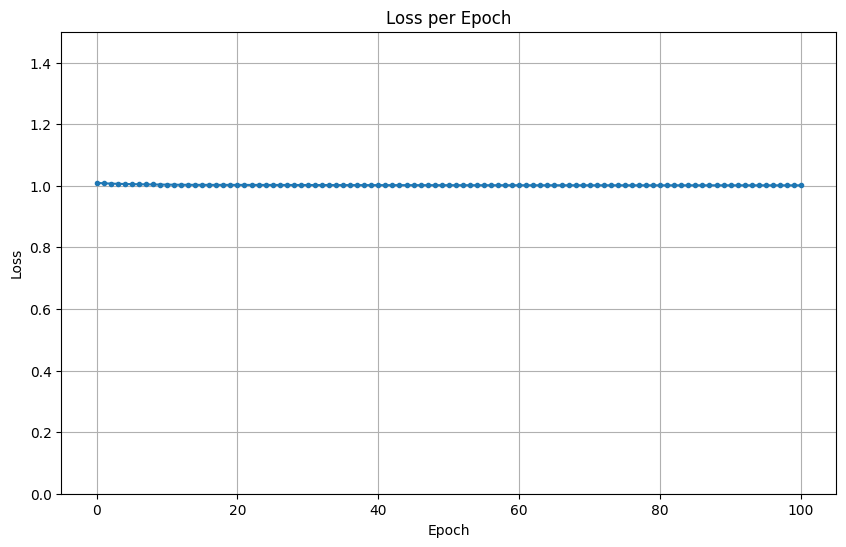

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, steps + 1), loss_values, marker='.')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.5])
plt.grid()
plt.show()